In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [ ]:
def plot(paths_XYs):

    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

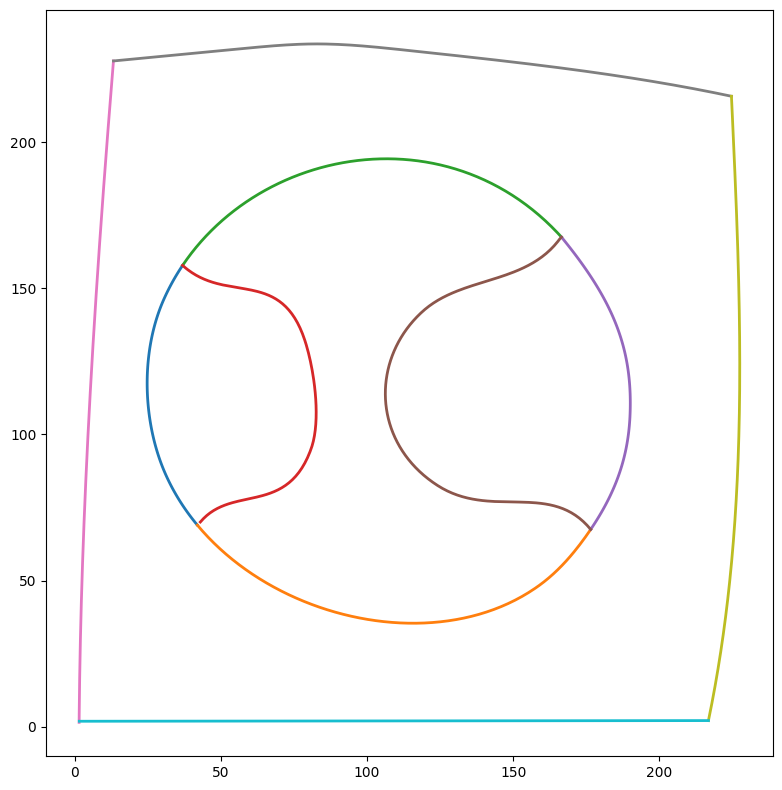

In [ ]:
csv_path = r'/content/frag0.csv'
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

In [ ]:
paths_XYs


[[array([[ 41.94200134,  68.98000336],
         [ 41.25960541,  69.81170654],
         [ 40.58875275,  70.65237427],
         [ 39.92960739,  71.50195312],
         [ 39.28233719,  72.36040497],
         [ 38.6471138 ,  73.22766876],
         [ 38.02410889,  74.10371399],
         [ 37.4134903 ,  74.98847961],
         [ 36.81542969,  75.88191986],
         [ 36.23009109,  76.78398895],
         [ 35.65765381,  77.69464874],
         [ 35.09827805,  78.6138382 ],
         [ 34.55213928,  79.54151917],
         [ 34.01940155,  80.47764587],
         [ 33.50024414,  81.42215729],
         [ 32.99482727,  82.37502289],
         [ 32.50332642,  83.33618164],
         [ 32.02590561,  84.30560303],
         [ 31.56274223,  85.28321838],
         [ 31.11400032,  86.26899719],
         [ 30.73366356,  87.13911438],
         [ 30.36473846,  88.0182724 ],
         [ 30.00725937,  88.90615845],
         [ 29.6612606 ,  89.80249023],
         [ 29.3267765 ,  90.70696259],
         [ 29.00383949,  

In [ ]:
column_names = ['curve','unknown','X_coord', "Y_coord"]

XY = pd.read_csv(r'/content/frag0.csv', names=column_names)
XY = XY.drop('unknown',axis=1)
XY

,curve,X_coord,Y_coord
0,0.0,41.942001,68.980003
1,0.0,41.259605,69.811707
2,0.0,40.588753,70.652374
3,0.0,39.929607,71.501953
4,0.0,39.282337,72.360405
...,...,...,...
1770,9.0,212.755249,2.102682
1771,9.0,213.760941,2.103762
1772,9.0,214.766632,2.104841
1773,9.0,215.772308,2.105921


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image
from io import BytesIO

def create_all_curves_image(df, image_size=(256, 256)):
    buf = BytesIO()
    plt.figure(figsize=(image_size[1] / 100, image_size[0] / 100), dpi=100)

    grouped = df.groupby('curve')
    colors = plt.cm.viridis(np.linspace(0, 1, len(grouped)))

    for (curve_id, group), color in zip(grouped, colors):
        x_coords = group['X_coord'].values
        y_coords = group['Y_coord'].values
        x_coords = np.clip(x_coords, 0, image_size[1] - 1)
        y_coords = np.clip(y_coords, 0, image_size[0] - 1)
        plt.plot(x_coords, y_coords, color=color, linewidth=2, label=f'Curve {int(curve_id)}')

    plt.xlim(0, image_size[1])
    plt.ylim(image_size[0], 0)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=100, transparent=False)
    plt.close()

    buf.seek(0)
    img = Image.open(buf)
    img_array = np.array(img)

    # Ensure image is in RGB format
    if img_array.ndim == 3 and img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]

    # Resize to 224x224 if not already
    img_resized = Image.fromarray(img_array).resize((224, 224))
    img_array_resized = np.array(img_resized)

    # Add batch dimension
    img_array_resized = np.expand_dims(img_array_resized, axis=0)

    return img_array_resized

def extract_features(image_array):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    features = base_model.predict(image_array)
    return features

# Example usage
image_array = create_all_curves_image(XY)

# Ensure the image array has 4 dimensions (batch size, height, width, channels)
print("Image array shape:", image_array.shape)

# Extract features
features = extract_features(image_array)

print("Features shape:", features.shape)

Image array shape: (1, 224, 224, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Features shape: (1, 7, 7, 2048)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


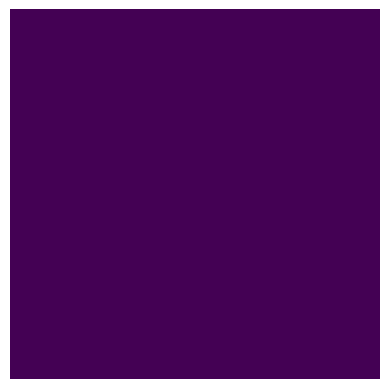

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import ResNet50

# Define a custom model for regularization
def create_regularization_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(3, activation='sigmoid')(x)  # Adjust output layer as needed for regularization

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='mse')  # Use an appropriate loss function
    return model

# Assume you have a model file or a trained model for shape regularization
model = create_regularization_model()

# Load your image and preprocess it
image_array = create_all_curves_image(XY)

# Predict the regularized output
regularized_output = model.predict(image_array)

# Post-process the output to generate an image
def post_process_output(output_array, image_size=(224, 224)):
    output_image = np.clip(output_array.squeeze(), 0, 255).astype(np.uint8)
    output_image = Image.fromarray(output_image)
    output_image = output_image.resize(image_size)
    return output_image

# Convert regularized output to image
output_image = post_process_output(regularized_output)

# Display the regularized image
import matplotlib.pyplot as plt

plt.imshow(output_image)
plt.axis('off')
plt.show()

In [ ]:
image_array

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[241, 228,  41],
         [241, 228,  41],
         [244, 229,  44],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[253, 231,  37],
         [253, 231,  37],
         [253, 231,  37],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[242, 228,  41],
         [241, 228,  41],
         [244, 229,  44],
         ...,
         [255, 255, 255],
        

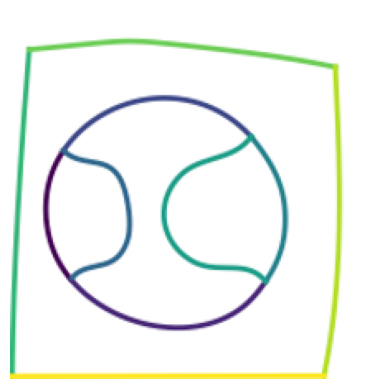

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure image has the correct shape (224, 224, 3)
image_array = image_array.squeeze()  # Remove batch dimension if necessary
image_array = np.clip(image_array, 0, 255).astype(np.uint8)

# Display the image
plt.imshow(image_array)
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import stylegan2  # Make sure to use a library that provides StyleGAN2 functionalities

# Load the StyleGAN2 model (modify according to your setup)
def load_stylegan2_model(model_path):
    # Assume you have a function to load the model
    # This is just a placeholder; adjust based on the actual implementation
    model = stylegan2.load_model(model_path)
    return model

# Preprocess your image
def preprocess_image(image_path, size=(256, 256)):
    image = Image.open(image_path).resize(size)
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

# Generate image using StyleGAN2
def generate_image_with_stylegan2(model, input_image):
    # Use the model to generate a regularized image
    # This is a placeholder; adjust based on the actual API of the StyleGAN2 library
    output_image = model.generate(input_image)
    return output_image

# Postprocess the image
def postprocess_image(image_array):
    image_array = (image_array * 255).astype(np.uint8)
    return Image.fromarray(image_array[0])

# Paths
model_path = 'path/to/stylegan2/model'
input_image_path = 'path/to/your/image.jpg'
output_image_path = 'path/to/output/image.jpg'

# Load model and preprocess image
stylegan2_model = load_stylegan2_model(model_path)
input_image = preprocess_image(input_image_path)

# Generate and save the output image
output_image_array = generate_image_with_stylegan2(stylegan2_model, input_image)
output_image = postprocess_image(output_image_array)
output_image.save(output_image_path)


In [ ]:
!rm -r /content/stylegan2